# Chapter 3: The completely randomized experiment and the Fisher randomization test

In [6]:
import itertools
# %% library loads
import numpy as np
import scipy as sp
# viz
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'IBM Plex Sans Condensed',
               'weight' : 'normal',
               'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (6, 5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [7]:
def permuter(N, N1):
    combos = np.array(list(itertools.combinations(range(N), N1)))
    # create an empty matrix of size N x (N choose N1)
    matrix = np.zeros((N, len(combos)))
    for i in range(len(combos)):
        matrix[combos[i], i] = 1
    return matrix


In [8]:
permuter(5, 3)


array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1., 1., 1., 0.],
       [1., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 1., 0., 1., 1.],
       [0., 0., 1., 0., 1., 1., 0., 1., 1., 1.]])

## illustration using lalonde data

In [9]:
# Laurence Wong's package has lalonde data
# !pip install git+https://github.com/laurencium/Causalinference
from causalinference.utils import lalonde_data
y, z, _ = lalonde_data()
y = y * 1000 # stored in 1000s of dollars in causalinference


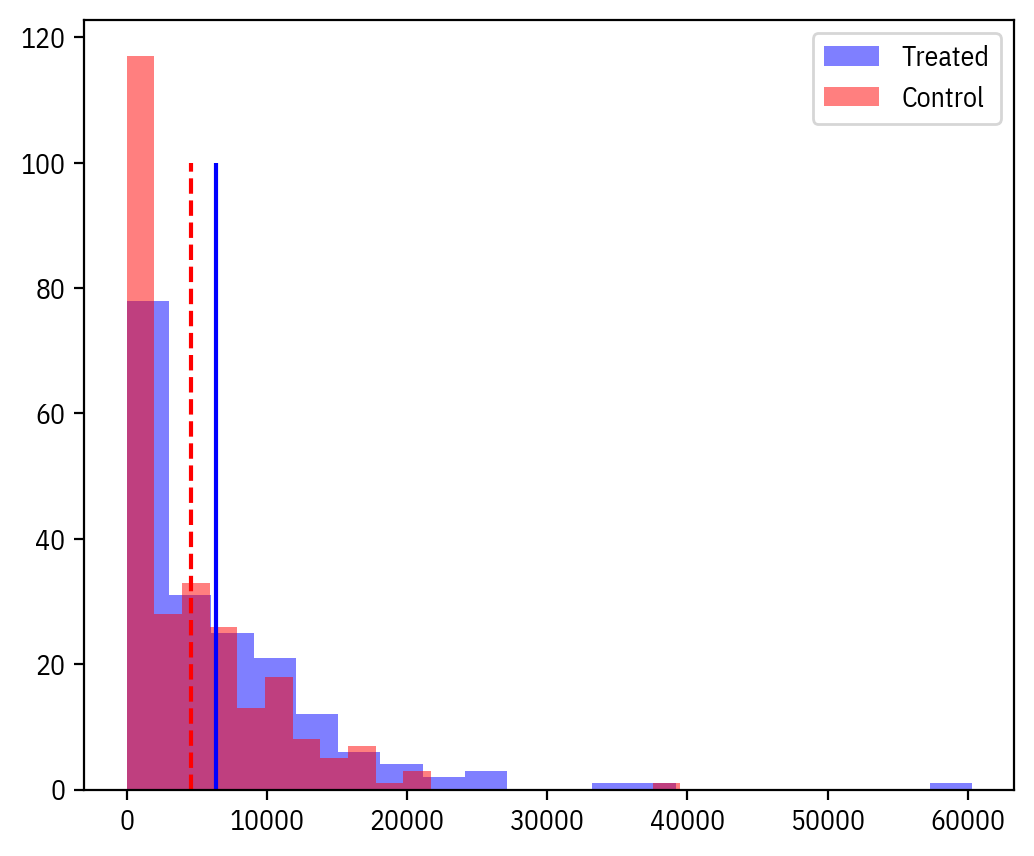

In [14]:
f, ax = plt.subplots(1, 1)
ax.hist(y[z==1], bins=20, color='blue', alpha=0.5, label='Treated')
ax.hist(y[z==0], bins=20, color='red', alpha=0.5, label='Control')
ax.vlines(y[z==1].mean(), 0, 100, color='blue', linestyle='-')
ax.vlines(y[z==0].mean(), 0, 100, color='red', linestyle='--')
ax.legend()
plt.show()


### FRT 

In [26]:
(tauhat := sp.stats.ttest_ind(y[z == 1], y[z == 0], equal_var=True)[0])


2.835321178307911

In [27]:
(student := sp.stats.ttest_ind(y[z == 1], y[z == 0], equal_var=False)[0])


2.674145786280093

In [28]:
# scipy's wilcoxon requires equal length vectors; so use mann-whitney
(W := sp.stats.mannwhitneyu(y[z == 1], y[z == 0])[0])


27402.5

In [29]:
(D := sp.stats.ks_2samp(y[z == 1], y[z == 0])[0])


0.13212058212058211

In [66]:
def one_perm():
    zperm = np.random.permutation(z)
    return [sp.stats.ttest_ind(y[zperm == 1], y[zperm == 0], equal_var=True)[0],
            sp.stats.ttest_ind(y[zperm == 1], y[zperm == 0], equal_var=False)[0],
            sp.stats.mannwhitneyu(y[zperm == 1], y[zperm == 0])[0],
            sp.stats.ks_2samp(y[zperm == 1], y[zperm == 0])[0],
    ]

MC = int(1e4)
result = np.zeros((MC, 4))
for i in range(MC):
    result[i] = one_perm()
Tauhat, Student, Wilcox, Ks = np.split(result, 4, axis=1)


In [67]:
print(exact_pvalue := np.c_[np.mean(Tauhat  >= tauhat),
                            np.mean(Student >= student),
                            np.mean(Wilcox  >= W),
                            np.mean(Ks      >= D)]
)


[[0.003  0.0032 0.004  0.0378]]


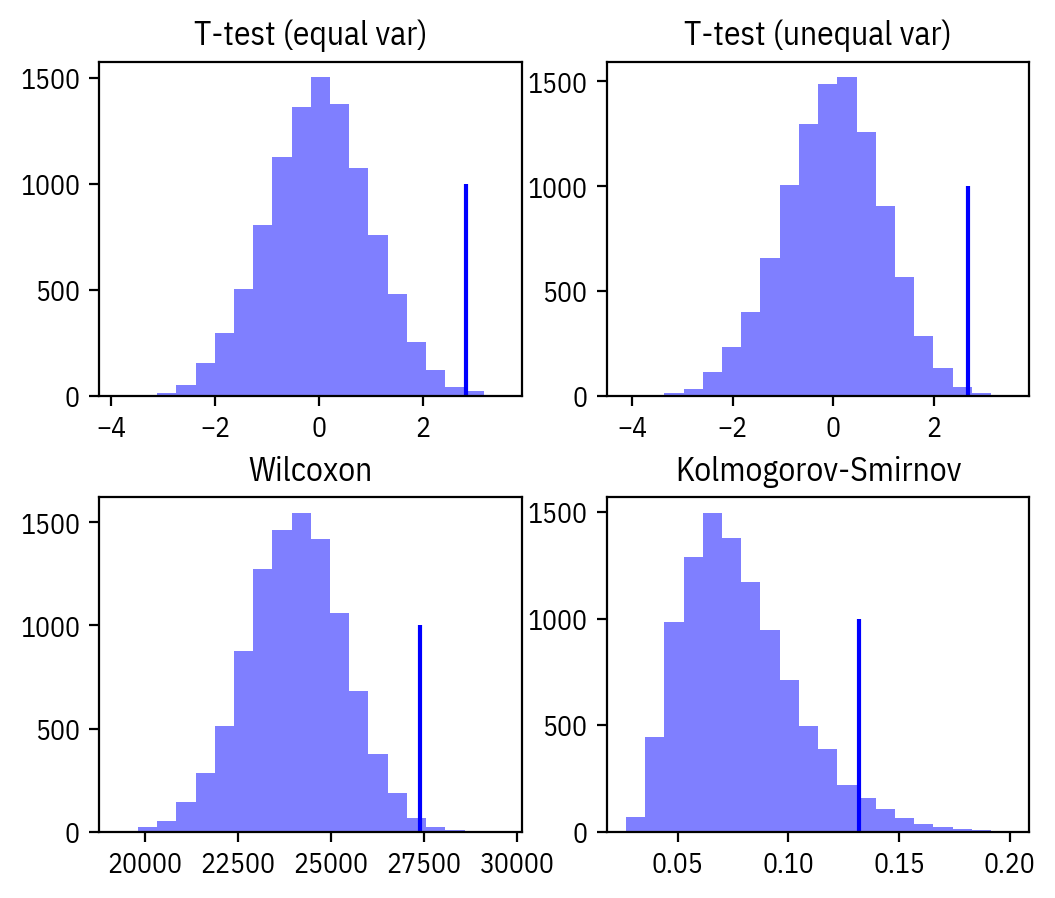

In [76]:
f, ax = plt.subplots(2, 2)

ax[0, 0].hist(Tauhat, bins=20, color='blue', alpha=0.5)
ax[0, 0].vlines(tauhat, 0, 1000, color='blue', linestyle='-')
ax[0, 0].title.set_text('T-test (equal var)')

ax[0, 1].hist(Student, bins=20, color='blue', alpha=0.5)
ax[0, 1].vlines(student, 0, 1000, color='blue', linestyle='-')
ax[0, 1].title.set_text('T-test (unequal var)')

ax[1, 0].hist(Wilcox, bins=20, color='blue', alpha=0.5)
ax[1, 0].vlines(W, 0, 1000, color='blue', linestyle='-')
ax[1, 0].title.set_text('Wilcoxon')

ax[1, 1].hist(Ks, bins=20, color='blue', alpha=0.5)
ax[1, 1].vlines(D, 0, 1000, color='blue', linestyle='-')
ax[1, 1].title.set_text('Kolmogorov-Smirnov')

f.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()
